# **Modelamiento**

## Importamos librerías necesarias

In [1]:
# importemos las librerías básicas a usar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

## Lectura de datos

In [2]:
df = pd.read_csv('datasets/data_to_model.csv', index_col=0)
df['Exited'] = df['Exited_C'].map({'Yes':1, 'No':0})
df.drop(columns=['Exited_C'], inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.select_dtypes('number').head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


## Baseline

A continuación de plantea una regresión logística como línea base, para tener como referencia su performance, y a partir de ahí intentar mejorar las métricas obtenidas con otros modelos y configuraciones

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

df2 = df.copy()

to_encode = df.select_dtypes('object').columns.tolist()
to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'), to_encode),
    ('scaler', MinMaxScaler(), to_scale)
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform='pandas')

X = df.drop(columns=['Exited'])
y = df.Exited.values
X = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
print(f"Tamaño de base de entrenamiento{X_train.shape}")
print(f"Tamaño de base de test{X_test.shape}")

Tamaño de base de entrenamiento(7500, 13)
Tamaño de base de test(2500, 13)


Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(random_state=1234)
lr.fit(X_train, y_train)
print(f"AUC para logistic regression: {roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]):.2f}")

AUC para logistic regression: 0.75


SVC

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C':[0.5, 1, 1.5, 5]}
grid = GridSearchCV(SVC(probability=True,random_state=1234), param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,18.561876,1.086302,0.183812,0.048051,5,poly,"{'C': 5, 'kernel': 'poly'}",0.821545,0.834995,0.826056,0.825990,0.831023,0.827922,0.004637,1
6,12.943251,2.247396,0.259137,0.123179,1.5,poly,"{'C': 1.5, 'kernel': 'poly'}",0.813353,0.825960,0.819120,0.813282,0.826918,0.819727,0.005884,2
3,12.771268,0.581014,0.171628,0.008375,1,poly,"{'C': 1, 'kernel': 'poly'}",0.811238,0.822016,0.815836,0.810570,0.821395,0.816211,0.004843,3
10,15.526398,1.023240,0.416215,0.096851,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.810586,0.812535,0.811539,0.803536,0.820612,0.811761,0.005441,4
0,9.849285,0.821348,0.179209,0.018833,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.804841,0.816482,0.811695,0.802309,0.815729,0.810211,0.005714,5


In [93]:
results_iter2 = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'])
print(f"AUC para support vector machine: {roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]),2), grid.best_params_
results_iter2 = pd.concat([results_iter2, aux], axis = 0, ignore_index=True)

AUC para support vector machine: 81.99%


Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

param_grid2 = {'max_depth': [10,15,20,25,30], 'min_samples_split':[60, 80, 100]}
grid2 = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid=param_grid2, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid2.fit(X_train, y_train)
pd.DataFrame(grid2.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.048863,0.003087,0.007023,0.000873,10,100,"{'max_depth': 10, 'min_samples_split': 100}",0.811951,0.841357,0.821174,0.827639,0.852513,0.830927,0.014427,1
1,0.052075,0.005258,0.009758,0.004388,10,80,"{'max_depth': 10, 'min_samples_split': 80}",0.799512,0.843850,0.822060,0.826336,0.847292,0.827810,0.017163,2
8,0.045989,0.001976,0.006851,0.000360,20,100,"{'max_depth': 20, 'min_samples_split': 100}",0.812024,0.844350,0.813308,0.819839,0.848704,0.827645,0.015704,3
11,0.050063,0.003098,0.008336,0.001363,25,100,"{'max_depth': 25, 'min_samples_split': 100}",0.812024,0.844350,0.813308,0.819839,0.848704,0.827645,0.015704,3
14,0.046304,0.005936,0.005626,0.000744,30,100,"{'max_depth': 30, 'min_samples_split': 100}",0.812024,0.844350,0.813308,0.819839,0.848704,0.827645,0.015704,3


In [94]:
print(f"AUC para decision tree: {roc_auc_score(y_test, grid2.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid2.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid2.best_estimator_.predict_proba(X_test)[:, 1]),2), grid2.best_params_
results_iter2 = pd.concat([results_iter2, aux], axis = 0, ignore_index=True)

AUC para decision tree: 82.46%


Random Forest Classifier

In [68]:
from sklearn.ensemble import RandomForestClassifier

param_grid3 = {'n_estimators': [100, 150, 200], 'max_depth': [10,15,20,25,30],'min_samples_split':[60, 80, 100]}
grid3 = GridSearchCV(RandomForestClassifier(random_state=1234), param_grid=param_grid3, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid3.fit(X_train, y_train)
pd.DataFrame(grid3.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.394804,0.011116,0.125400,0.016251,10,60,100,"{'max_depth': 10, 'min_samples_split': 60, 'n_...",0.850732,0.859160,0.854471,0.867362,0.874717,0.861288,0.008714,1
10,1.550598,0.226907,0.087862,0.015401,15,60,150,"{'max_depth': 15, 'min_samples_split': 60, 'n_...",0.850500,0.859806,0.851803,0.867007,0.876444,0.861112,0.009704,2
1,2.278489,0.184957,0.138399,0.020487,10,60,150,"{'max_depth': 10, 'min_samples_split': 60, 'n_...",0.850305,0.857745,0.854285,0.867056,0.875858,0.861050,0.009246,3
28,1.473101,0.172595,0.092622,0.017158,25,60,150,"{'max_depth': 25, 'min_samples_split': 60, 'n_...",0.851488,0.858935,0.851679,0.866300,0.876222,0.860925,0.009396,4
37,1.265165,0.068216,0.065044,0.006079,30,60,150,"{'max_depth': 30, 'min_samples_split': 60, 'n_...",0.851488,0.858935,0.851679,0.866300,0.876222,0.860925,0.009396,4


In [95]:
print(f"AUC para random forest: {roc_auc_score(y_test, grid3.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid3.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid3.best_estimator_.predict_proba(X_test)[:, 1]),2), grid3.best_params_
results_iter2 = pd.concat([results_iter2, aux], axis = 0, ignore_index=True)

AUC para random forest: 85.70%


In [13]:
from sklearn.neighbors import KNeighborsClassifier

param_grid4 = {'n_neighbors': [5, 10, 15], 'p': [1,2],'algorithm':['ball_tree', 'kd_tree', 'brute']}
grid4 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid4, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid4.fit(X_train, y_train)
pd.DataFrame(grid4.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.028939,0.008085,0.307961,0.064909,ball_tree,15,1,"{'algorithm': 'ball_tree', 'n_neighbors': 15, ...",0.773626,0.783426,0.778789,0.774210,0.787799,0.779570,0.005427,1
10,0.036674,0.007704,0.313382,0.054911,kd_tree,15,1,"{'algorithm': 'kd_tree', 'n_neighbors': 15, 'p...",0.773626,0.783426,0.778789,0.774210,0.787799,0.779570,0.005427,1
16,0.005456,0.001485,0.336534,0.023002,brute,15,1,"{'algorithm': 'brute', 'n_neighbors': 15, 'p': 1}",0.773626,0.783426,0.778789,0.774210,0.787799,0.779570,0.005427,1
8,0.032803,0.004651,0.259442,0.040517,kd_tree,10,1,"{'algorithm': 'kd_tree', 'n_neighbors': 10, 'p...",0.759220,0.775033,0.776616,0.767807,0.767422,0.769219,0.006225,4
14,0.007049,0.001877,0.394731,0.031293,brute,10,1,"{'algorithm': 'brute', 'n_neighbors': 10, 'p': 1}",0.759220,0.775033,0.776616,0.767807,0.767422,0.769219,0.006225,4


In [96]:
print(f"AUC para k-nn classifier: {roc_auc_score(y_test, grid4.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid4.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid4.best_estimator_.predict_proba(X_test)[:, 1]),2), grid4.best_params_
results_iter2 = pd.concat([results_iter2, aux], axis = 0, ignore_index=True)

AUC para k-nn classifier: 77.22%


Como resultado se obtiene:

In [100]:
pd.set_option('display.max_colwidth', 200)
results_iter2

,Modelo,AUC,Mejores parametros
0,SVC,0.82,"{'C': 5, 'kernel': 'poly'}"
1,DecisionTreeClassifier,0.82,"{'max_depth': 10, 'min_samples_split': 100}"
2,RandomForestClassifier,0.86,"{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 100}"
3,KNeighborsClassifier,0.77,"{'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1}"


### Feature selection

Se escogeran las variables que tengan mayor relación con la variable objetivo

In [102]:
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_cols = df2.drop(columns=cat_cols).columns.tolist()
num_cols.remove('Exited')

Variables numéricas

In [103]:
from sklearn.feature_selection import f_classif, SelectKBest

X = df2[num_cols]
y = df2.Exited.values

num_kbest = SelectKBest(f_classif,k=4).set_output(transform='pandas')
best_nums = num_kbest.fit_transform(df2[num_cols], y)

Variables categóricas

In [104]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder

# codificamos las variables categóricas
encoder = OrdinalEncoder().set_output(transform='pandas')
X = df2[cat_cols]
X =encoder.fit_transform(X)
y = df2.Exited.values
cat_kbest = SelectKBest(chi2,k=3).set_output(transform='pandas')
best_cats = cat_kbest.fit_transform(X, y)

Nuevo dataframe

In [105]:
new_df = pd.concat([best_nums, df2[cat_cols][best_cats.columns.tolist()]], axis = 1)
new_df['Exited'] = y
new_df.head()

,CreditScore,Age,Balance,NumOfProducts,Geography,Gender,IsActiveMember,Exited
0,619.0,42.0,0.00,1.0,France,Female,1,1
1,608.0,41.0,83807.86,1.0,Spain,Female,1,0
2,502.0,42.0,159660.80,3.0,France,Female,0,1
3,699.0,39.0,0.00,2.0,France,Female,0,0
4,850.0,43.0,125510.82,1.0,Spain,Female,1,0


Nuevos datos de prueba y entrenamiento

In [106]:
to_encode = new_df.select_dtypes('object').columns.tolist()
to_scale = ['CreditScore', 'Age', 'Balance', 'NumOfProducts']

transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'), to_encode),
    ('scaler', MinMaxScaler(), to_scale)
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform='pandas')

X = new_df.drop(columns=['Exited'])
y = new_df.Exited.values
X = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
print(f"Tamaño de base de entrenamiento: {X_train.shape}")
print(f"Tamaño de base de test: {X_test.shape}")

Tamaño de base de entrenamiento: (7500, 10)
Tamaño de base de test: (2500, 10)


SVC

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C':[0.5, 1, 1.5, 5]}
grid = GridSearchCV(SVC(probability=True, random_state=1234), param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,13.873835,1.815077,0.193664,0.046855,5,poly,"{'C': 5, 'kernel': 'poly'}",0.820111,0.826507,0.832107,0.821783,0.839998,0.828101,0.007265,1
10,11.856137,1.712665,0.321906,0.086025,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.814292,0.826015,0.821635,0.814686,0.831921,0.821710,0.006740,2
6,11.150445,1.569302,0.231059,0.066071,1.5,poly,"{'C': 1.5, 'kernel': 'poly'}",0.809891,0.822758,0.820385,0.816640,0.833968,0.820728,0.007921,3
3,11.701940,1.791282,0.210523,0.055359,1,poly,"{'C': 1, 'kernel': 'poly'}",0.808454,0.821868,0.816654,0.813019,0.829302,0.817859,0.007216,4
7,13.385809,2.085562,0.367821,0.084124,1.5,rbf,"{'C': 1.5, 'kernel': 'rbf'}",0.806552,0.821745,0.813471,0.804973,0.825544,0.814457,0.008117,5


In [110]:
print(f"AUC para support vector machine: {roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
results_iter3 = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'])
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]),2), grid.best_params_
results_iter3 = pd.concat([results_iter3, aux], axis = 0, ignore_index=True)

AUC para support vector machine: 82.05%


Decision tree

In [108]:
from sklearn.tree import DecisionTreeClassifier

param_grid2 = {'max_depth': [10,15,20,25,30], 'min_samples_split':[60, 80, 100]}
grid2 = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid=param_grid2, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid2.fit(X_train, y_train)
pd.DataFrame(grid2.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.022457,0.001608,0.005337,0.000356,10,100,"{'max_depth': 10, 'min_samples_split': 100}",0.809491,0.847061,0.837956,0.838348,0.859603,0.838492,0.016495,1
8,0.021303,0.002100,0.004702,0.000600,20,100,"{'max_depth': 20, 'min_samples_split': 100}",0.813338,0.844351,0.826547,0.836800,0.855235,0.835254,0.014426,2
11,0.023599,0.001797,0.005484,0.001399,25,100,"{'max_depth': 25, 'min_samples_split': 100}",0.813338,0.844351,0.826547,0.836800,0.855235,0.835254,0.014426,2
14,0.022910,0.002410,0.004171,0.000766,30,100,"{'max_depth': 30, 'min_samples_split': 100}",0.813338,0.844351,0.826547,0.836800,0.855235,0.835254,0.014426,2
5,0.032108,0.006696,0.008196,0.002198,15,100,"{'max_depth': 15, 'min_samples_split': 100}",0.812564,0.844351,0.826547,0.837788,0.854145,0.835079,0.014398,5


In [111]:
print(f"AUC para decision tree: {roc_auc_score(y_test, grid2.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid2.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid2.best_estimator_.predict_proba(X_test)[:, 1]),2), grid2.best_params_
results_iter3 = pd.concat([results_iter3, aux], axis = 0, ignore_index=True)

AUC para decision tree: 83.00%


Random Forest Classifier

In [112]:
param_grid3 = {'n_estimators': [100, 150, 200], 'max_depth': [10,15,20,25,30],'min_samples_split':[60, 80, 100]}
grid3 = GridSearchCV(RandomForestClassifier(random_state=1234), param_grid=param_grid3, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid3.fit(X_train, y_train)
pd.DataFrame(grid3.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.165777,0.154608,0.058593,0.002613,10,60,100,"{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 100}",0.852347,0.864572,0.861292,0.868360,0.877641,0.864842,0.008307,1
1,1.665835,0.165937,0.103817,0.028716,10,60,150,"{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 150}",0.852919,0.865274,0.859198,0.868632,0.878054,0.864816,0.008522,2
11,1.751853,0.238072,0.117260,0.033717,15,60,200,"{'max_depth': 15, 'min_samples_split': 60, 'n_estimators': 200}",0.851233,0.866508,0.859529,0.867123,0.878884,0.864656,0.009148,3
2,2.184196,0.362292,0.118987,0.016858,10,60,200,"{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 200}",0.852750,0.865378,0.858103,0.868684,0.877978,0.864579,0.008705,4
38,2.228587,0.018615,0.086383,0.006517,30,60,200,"{'max_depth': 30, 'min_samples_split': 60, 'n_estimators': 200}",0.850593,0.867171,0.859157,0.866692,0.878884,0.864499,0.009389,5


In [113]:
print(f"AUC para random forest: {roc_auc_score(y_test, grid3.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid3.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid3.best_estimator_.predict_proba(X_test)[:, 1]),2), grid3.best_params_
results_iter3 = pd.concat([results_iter3, aux], axis = 0, ignore_index=True)

AUC para random forest: 85.77%


KNN Classifier

In [114]:
param_grid4 = {'n_neighbors': [5, 10, 15], 'p': [1,2],'algorithm':['ball_tree', 'kd_tree', 'brute']}
grid4 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid4, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid4.fit(X_train, y_train)
pd.DataFrame(grid4.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.010816,0.004961,0.566743,0.028501,brute,15,1,"{'algorithm': 'brute', 'n_neighbors': 15, 'p': 1}",0.823338,0.827989,0.841089,0.823278,0.831699,0.829479,0.006605,1
4,0.023106,0.007485,0.152094,0.013544,ball_tree,15,1,"{'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1}",0.823338,0.827989,0.841089,0.823224,0.831693,0.829467,0.006614,2
10,0.026274,0.008411,0.206914,0.008717,kd_tree,15,1,"{'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 1}",0.823282,0.827989,0.841089,0.823278,0.831693,0.829466,0.006615,3
5,0.017998,0.003081,0.133127,0.015708,ball_tree,15,2,"{'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 2}",0.816844,0.826736,0.839668,0.824836,0.832575,0.828132,0.007656,4
11,0.020828,0.002472,0.159575,0.009156,kd_tree,15,2,"{'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 2}",0.816844,0.826736,0.839668,0.824836,0.832575,0.828132,0.007656,4


In [115]:
print(f"AUC para k-nn classifier: {roc_auc_score(y_test, grid4.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")
aux = pd.DataFrame(columns=['Modelo', 'AUC', 'Mejores parametros'], index=[0])
aux.iloc[-1,:] = grid4.best_estimator_.__class__.__name__, round(roc_auc_score(y_test, grid4.best_estimator_.predict_proba(X_test)[:, 1]),2), grid4.best_params_
results_iter3 = pd.concat([results_iter3, aux], axis = 0, ignore_index=True)

AUC para k-nn classifier: 81.20%


Como resultado se obtiene:

In [116]:
results_iter3 

,Modelo,AUC,Mejores parametros
0,SVC,0.82,"{'C': 5, 'kernel': 'poly'}"
1,DecisionTreeClassifier,0.83,"{'max_depth': 10, 'min_samples_split': 100}"
2,RandomForestClassifier,0.86,"{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 100}"
3,KNeighborsClassifier,0.81,"{'algorithm': 'brute', 'n_neighbors': 15, 'p': 1}"


In [ ]:
results_iter2.to_csv('iter1.csv', index=False)

## Añadimos pesos a las clases

In [57]:
param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C':[0.5, 1, 1.5, 5]}
grid = GridSearchCV(SVC(probability=True, class_weight={0:0.2,1:0.8}, random_state=1234), param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,12.385127,0.388342,0.249161,0.009730,5,poly,"{'C': 5, 'kernel': 'poly'}",0.844467,0.848923,0.852533,0.851053,0.852065,0.849808,0.002945,1
6,12.044806,0.718088,0.290833,0.021023,1.5,poly,"{'C': 1.5, 'kernel': 'poly'}",0.839623,0.838454,0.846868,0.836828,0.847667,0.841888,0.004488,2
10,13.584996,0.965248,0.410039,0.034759,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.837784,0.833509,0.845089,0.831839,0.847716,0.839187,0.006258,3
3,12.618514,1.185959,0.301481,0.037476,1,poly,"{'C': 1, 'kernel': 'poly'}",0.836842,0.830908,0.843195,0.829584,0.845803,0.837266,0.006444,4
0,13.374558,0.521672,0.310470,0.007908,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.825259,0.818017,0.832841,0.813736,0.835219,0.825015,0.008266,5


In [27]:
print(f"AUC para support vector machine: {roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para support vector machine: 85.85%


Decision tree

In [59]:
param_grid2 = {'max_depth': [10,15,20,25,30], 'min_samples_split':[60, 80, 100]}
grid2 = GridSearchCV(DecisionTreeClassifier(class_weight={0:0.2,1:0.8}, random_state=1234), param_grid=param_grid2, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid2.fit(X_train, y_train)
pd.DataFrame(grid2.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.030145,0.010083,0.012502,0.012580,10,100,"{'max_depth': 10, 'min_samples_split': 100}",0.819087,0.841832,0.826871,0.842334,0.841171,0.834259,0.009540,1
5,0.046849,0.007200,0.011349,0.008586,15,100,"{'max_depth': 15, 'min_samples_split': 100}",0.820948,0.842235,0.821796,0.839249,0.840247,0.832895,0.009461,2
8,0.035056,0.003139,0.008682,0.002504,20,100,"{'max_depth': 20, 'min_samples_split': 100}",0.816508,0.842235,0.821796,0.839249,0.840247,0.832007,0.010672,3
11,0.023135,0.001388,0.005930,0.000500,25,100,"{'max_depth': 25, 'min_samples_split': 100}",0.816508,0.842235,0.821796,0.839249,0.840247,0.832007,0.010672,3
14,0.021790,0.001967,0.003825,0.000440,30,100,"{'max_depth': 30, 'min_samples_split': 100}",0.816508,0.842235,0.821796,0.839249,0.840247,0.832007,0.010672,3


In [60]:
print(f"AUC para decision tree: {roc_auc_score(y_test, grid2.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para decision tree: 83.40%


Random Forest

In [65]:
param_grid3 = {'n_estimators': [100, 150, 200], 'max_depth': [10,15,20,25,30],'min_samples_split':[60, 80, 100]}
grid3 = GridSearchCV(RandomForestClassifier(class_weight={0:0.2,1:0.8}, random_state=1234), param_grid=param_grid3, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid3.fit(X_train, y_train)
pd.DataFrame(grid3.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.820721,0.118969,0.058558,0.022026,10,60,150,"{'max_depth': 10, 'min_samples_split': 60, 'n_...",0.862559,0.858236,0.841604,0.864997,0.839671,0.853413,0.010672,1
19,0.955789,0.187740,0.050286,0.006790,20,60,150,"{'max_depth': 20, 'min_samples_split': 60, 'n_...",0.861802,0.857884,0.841252,0.864856,0.841252,0.853409,0.010169,2
28,0.840422,0.071378,0.052275,0.006834,25,60,150,"{'max_depth': 25, 'min_samples_split': 60, 'n_...",0.861802,0.857884,0.841252,0.864856,0.841252,0.853409,0.010169,2
37,0.830564,0.058462,0.051417,0.003310,30,60,150,"{'max_depth': 30, 'min_samples_split': 60, 'n_...",0.861802,0.857884,0.841252,0.864856,0.841252,0.853409,0.010169,2
10,0.835821,0.094967,0.058197,0.010720,15,60,150,"{'max_depth': 15, 'min_samples_split': 60, 'n_...",0.861802,0.857884,0.841252,0.864856,0.841252,0.853409,0.010169,2


In [17]:
print(f"AUC para random forest: {roc_auc_score(y_test, grid3.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para random forest: 85.78%


## Balanceo de clases

In [30]:
zeros = new_df[new_df['Exited']==0].sample(frac= 0.35)
ones = new_df[new_df['Exited']==1]
print(f"Shape de solo ceros: {zeros.shape}")
print(f"Shape de solo unos:{ones.shape}")

Shape de solo ceros: (2787, 8)
Shape de solo unos:(2037, 8)


In [42]:
new_df2 = pd.concat([zeros, ones], axis = 0)

to_encode = new_df2.select_dtypes('object').columns.tolist()
to_scale = ['CreditScore', 'Age', 'Balance', 'NumOfProducts']

transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(sparse=False, handle_unknown='ignore'), to_encode),
    ('scaler', MinMaxScaler(), to_scale)
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform='pandas')

X = new_df2.drop(columns=['Exited'])
y = new_df2.Exited.values
X = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
print(f"Tamaño de base de entrenamiento: {X_train.shape}")
print(f"Tamaño de base de test: {X_test.shape}")

Tamaño de base de entrenamiento: (3618, 10)
Tamaño de base de test: (1206, 10)


SVC

In [37]:
param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C':[0.5, 1, 1.5, 5]}
grid = GridSearchCV(SVC(probability=True, random_state=1234), param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid.fit(X_train, y_train)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,2.863726,0.402396,0.059504,0.005230,5,poly,"{'C': 5, 'kernel': 'poly'}",0.860388,0.841455,0.822311,0.842380,0.839522,0.841211,0.012077,1
6,2.180510,0.157857,0.066541,0.007074,1.5,poly,"{'C': 1.5, 'kernel': 'poly'}",0.855881,0.840378,0.815489,0.842215,0.829225,0.836638,0.013547,2
3,2.179663,0.156398,0.066288,0.003345,1,poly,"{'C': 1, 'kernel': 'poly'}",0.851014,0.838966,0.812445,0.843476,0.822413,0.833663,0.014158,3
10,2.627108,0.398211,0.091193,0.007770,5,rbf,"{'C': 5, 'kernel': 'rbf'}",0.854287,0.837178,0.816348,0.828818,0.831026,0.833531,0.012393,4
0,2.213998,0.184425,0.075712,0.006729,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.836501,0.833284,0.801800,0.841299,0.810167,0.824610,0.015647,5


In [38]:
print(f"AUC para support vector machine: {roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para support vector machine: 85.92%


Decision Tree

In [46]:
param_grid2 = {'max_depth': [10,15,20,25,30], 'min_samples_split':[60, 80, 100]}
grid2 = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid=param_grid2, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid2.fit(X_train, y_train)
pd.DataFrame(grid2.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.011102,0.000741,0.005194,0.000544,10,100,"{'max_depth': 10, 'min_samples_split': 100}",0.844898,0.832636,0.830373,0.854548,0.840297,0.840550,0.008731,1
5,0.012860,0.001452,0.007509,0.003112,15,100,"{'max_depth': 15, 'min_samples_split': 100}",0.843449,0.832636,0.830373,0.847959,0.838202,0.838524,0.006550,2
8,0.014076,0.002783,0.008268,0.003849,20,100,"{'max_depth': 20, 'min_samples_split': 100}",0.843449,0.832636,0.830373,0.847959,0.838202,0.838524,0.006550,2
11,0.012671,0.001103,0.005879,0.001117,25,100,"{'max_depth': 25, 'min_samples_split': 100}",0.843449,0.832636,0.830373,0.847959,0.838202,0.838524,0.006550,2
14,0.012203,0.002979,0.003488,0.000655,30,100,"{'max_depth': 30, 'min_samples_split': 100}",0.843449,0.832636,0.830373,0.847959,0.838202,0.838524,0.006550,2


In [47]:
print(f"AUC para decision tree: {roc_auc_score(y_test, grid2.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para decision tree: 84.77%


Random Forest Classifier

In [70]:
param_grid3 = {'n_estimators': [100, 150, 200], 'max_depth': [10,15,20,25,30],'min_samples_split':[60, 80, 100]}
grid3 = GridSearchCV(RandomForestClassifier(random_state=1234), param_grid=param_grid3, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid3.fit(X_train, y_train)
pd.DataFrame(grid3.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.905058,0.168435,0.054538,0.007618,10,60,150,"{'max_depth': 10, 'min_samples_split': 60, 'n_...",0.864301,0.860507,0.843988,0.870298,0.841456,0.856110,0.011397,1
19,0.943181,0.167182,0.065180,0.020621,20,60,150,"{'max_depth': 20, 'min_samples_split': 60, 'n_...",0.865043,0.860194,0.844191,0.869930,0.841190,0.856110,0.011421,2
28,0.900466,0.078425,0.057071,0.004551,25,60,150,"{'max_depth': 25, 'min_samples_split': 60, 'n_...",0.865043,0.860194,0.844191,0.869930,0.841190,0.856110,0.011421,2
37,0.786528,0.034340,0.049395,0.002991,30,60,150,"{'max_depth': 30, 'min_samples_split': 60, 'n_...",0.865043,0.860194,0.844191,0.869930,0.841190,0.856110,0.011421,2
0,0.651788,0.124577,0.051155,0.009289,10,60,100,"{'max_depth': 10, 'min_samples_split': 60, 'n_...",0.864747,0.859949,0.843668,0.870854,0.841197,0.856083,0.011695,5


In [72]:
print(f"AUC para random forest: {roc_auc_score(y_test, grid3.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para random forest: 86.33%


KNN Classifier

In [55]:
param_grid4 = {'n_neighbors': [5, 10, 15], 'p': [1,2],'algorithm':['ball_tree', 'kd_tree', 'brute']}
grid4 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid4, n_jobs=-1, scoring='roc_auc', cv = 5, return_train_score=False)
grid4.fit(X_train, y_train)
pd.DataFrame(grid4.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.006496,0.000372,0.038668,0.007555,ball_tree,15,1,"{'algorithm': 'ball_tree', 'n_neighbors': 15, ...",0.836973,0.823263,0.815704,0.813502,0.816603,0.821209,0.008528,1
10,0.009548,0.002067,0.035195,0.001731,kd_tree,15,1,"{'algorithm': 'kd_tree', 'n_neighbors': 15, 'p...",0.836973,0.823263,0.815704,0.813502,0.816603,0.821209,0.008528,1
16,0.005845,0.001797,0.069894,0.003088,brute,15,1,"{'algorithm': 'brute', 'n_neighbors': 15, 'p': 1}",0.836973,0.823263,0.815704,0.813502,0.816603,0.821209,0.008528,1
8,0.009026,0.002701,0.030300,0.004302,kd_tree,10,1,"{'algorithm': 'kd_tree', 'n_neighbors': 10, 'p...",0.838754,0.826427,0.814599,0.798206,0.815436,0.818685,0.013486,4
14,0.005439,0.001100,0.107543,0.014445,brute,10,1,"{'algorithm': 'brute', 'n_neighbors': 10, 'p': 1}",0.838754,0.826427,0.814599,0.798206,0.815436,0.818685,0.013486,4


In [56]:
print(f"AUC para k-nn classifier: {roc_auc_score(y_test, grid4.best_estimator_.predict_proba(X_test)[:, 1]):.2%}")

AUC para k-nn classifier: 83.08%


### Escogemos el mejor modelo

En este caso se obtiene que el mejor modelo es el Random Forest Classifier un ajuste en los pesos de las clases después de haber realizado feature engineering. Los parámetros son:

In [73]:
grid3.best_params_

{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 150}

#### Métricas generales para el mejor modelo

In [74]:
best_model = grid3.best_estimator_
print('---------- Metricas de clasificación para Random Forest Classifier en entrenamiento ----------\n')
print(classification_report(y_train, grid3.predict(X_train)))

---------- Metricas de clasificación para Random Forest Classifier en entrenamiento ----------

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2081
           1       0.82      0.73      0.77      1537

    accuracy                           0.82      3618
   macro avg       0.82      0.81      0.81      3618
weighted avg       0.82      0.82      0.82      3618



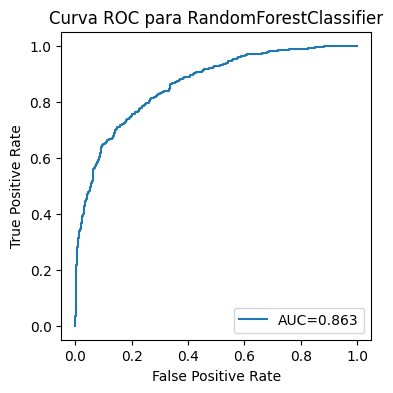

In [75]:
from src.utils import plot_roc_curve

plot_roc_curve(best_model, X_test, y_test)

Confusion matrix, without normalization


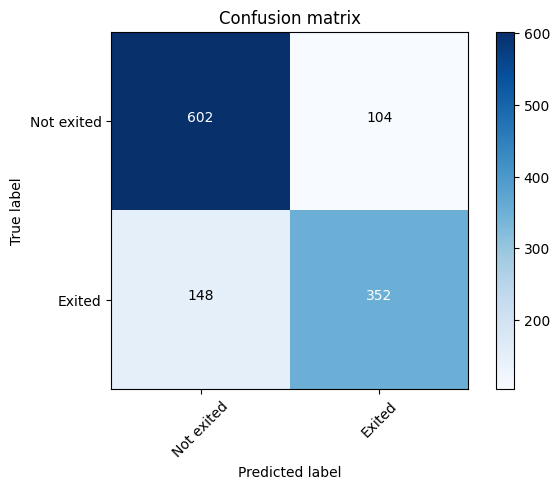

In [76]:
from sklearn.metrics import confusion_matrix
from src.utils import plot_confusion_matrix

cm = confusion_matrix(y_test, best_model.predict(X_test))

plot_confusion_matrix(cm, classes=['Not exited', 'Exited'], normalize=False)